In [1]:
!pip install mxnet-cu110

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 327.3 MB 5.9 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
import os
import time
from types import ModuleType
from typing import Union

import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import scipy.io as sio
import scipy.stats as sst
from google.colab import drive
from mxnet import Context, autograd, gluon, nd, init
from mxnet.gluon import ParameterDict, loss, nn
from mxnet.gluon.nn import Dense, HybridBlock, HybridSequential
from mxnet.io import NDArrayIter
from mxnet.ndarray import NDArray
from PIL import Image
np.random.seed(37)

In [3]:
ctx = mx.cpu()  # gpu -> cpu because colab sucks >:(
from google.colab import drive
drive.mount('/gdrive', force_remount=False)

Mounted at /gdrive


In [4]:
class Affine(HybridBlock):
    def __init__(self, fov) -> None:
        super().__init__()
        self.fov = fov
        with self.name_scope():
            self.theta = self.params.get("theta", shape=(1, 6))

    def hybrid_forward(self, F: ModuleType, x: NDArray, theta: NDArray) -> NDArray:
        # the target grid is said to be the receptive field (RF) of the voxel
        # i.e., the input should be of such a size that the output of the layer 
        # of interest is a scalar (after cross correlation with the kernel)
        return F.BilinearSampler(x, F.GridGenerator(F.broadcast_to(theta, (x.shape[0], 6)), "affine", (self.fov,self.fov)))

In [5]:
class AffineSimple(HybridBlock):
    def __init__(self, fov) -> None:
        super().__init__()
        self.fov = fov
        with self.name_scope():
            self.theta_sc = self.params.get("theta_sc", shape=(1, 1))
            self.theta_tr = self.params.get("theta_tr", shape=(1, 2))

    def hybrid_forward(self, F: ModuleType, x: NDArray, theta_sc: NDArray, theta_tr: NDArray) -> NDArray:
        s = F.Activation(theta_sc, "sigmoid")
        t = F.Activation(theta_tr, "tanh")
        
        _theta = F.Concat(s[0], F.zeros((1)), t[0, 0], F.zeros((1)), s[0], t[0, 1], dim=0)[None]
        _image = F.BilinearSampler(x, F.GridGenerator(F.broadcast_to(_theta, (x.shape[0], 6)), "affine", (self.fov, self.fov)))
        return _image

In [6]:
class Alexnet(HybridBlock):
    def __init__(self, layer: int) -> None:
        super(Alexnet, self).__init__()
        self.fov = [16, 32, 32, 32, 64, 224, 224, 224]
        self.layer = layer  # starting layer
        with self.name_scope():
            self.features = nn.HybridSequential("")
            with self.features.name_scope():
                if layer >= 1:
                    self.features.add(nn.Conv2D(64, 11, 4, 2, activation="relu"))
                    self.features.add(nn.MaxPool2D(3, 2))
                if layer >= 2:
                    self.features.add(nn.Conv2D(192, 5, padding=2, activation="relu"))
                    self.features.add(nn.MaxPool2D(3, 2))
                if layer >= 3:
                    self.features.add(nn.Conv2D(384, 3, padding=1, activation="relu"))
                if layer >= 4:
                    self.features.add(nn.Conv2D(256, 3, padding=1, activation="relu"))
                if layer >= 5:
                    self.features.add(nn.Conv2D(256, 3, padding=1, activation="relu"))
                    self.features.add(nn.MaxPool2D(3, 2))
                if layer >= 6:
                    self.features.add(nn.Flatten())
                    self.features.add(nn.Dense(4096, activation="relu"))
                    self.features.add(nn.Dropout(0.5))
                if layer >= 7:
                    self.features.add(nn.Dense(4096, activation="relu"))
                    self.features.add(nn.Dropout(0.5))
            if layer == 8:
                self.output = nn.Dense(1000)
          # should be the same as the .pth file, taken from pretrained mxnet.gluon.model_zoo.vision model weights
        self.load_parameters("/gdrive/MyDrive/Thesis/alexnet-44335d1f.params", ctx=ctx, ignore_extra=True)
        

    def hybrid_forward(self, F: ModuleType, x: nd.NDArray) -> nd.NDArray:
        return self.output(self.features(x)) if self.layer == 8 else self.features(x)

In [7]:
class Response(HybridSequential):
    def __init__(self) -> None:
        super().__init__()

        # we predict the response of 1 voxel
        with self.name_scope():
            self.add(Dense(1, in_units=64))  # hardcoded for layer 1

In [8]:
# prepreprocess images *for alexnet*
def preprocess(x_list):
    # zscore and divide by 255, transpose (2, 0, 1)
    # x_list contains values x of shape (batch_size, channels, width, height)
    
    mean = np.array((0.485, 0.456, 0.406))[None, None]
    std = np.array((0.229, 0.224, 0.225))[None, None]

    X = []
    for x in x_list:
        img = Image.fromarray(np.uint8(x)).convert("RGB")  # might be unnecessary
        x = (np.asarray(img)).astype("f") / 255
        x = mx.image.color_normalize(nd.array(x, ctx=ctx),
                                      mean=nd.array(mean),
                                      std=nd.array(std))
        X.append(x.asnumpy().transpose(2, 0, 1))
        # gpu -> cpu because colab sucks
    return nd.array(X).as_in_context(ctx)

def visualize(x_list):
    X = []
    mean = np.array((0.485, 0.456, 0.406))[None, None]
    std = np.array((0.229, 0.224, 0.225))[None, None]
    for i, x in enumerate(x_list):
        x = np.transpose(x.asnumpy(), (1, 2, 0))
        x = x * std + mean
        x *= 255
        X.append(np.uint8(np.transpose(x, (2, 0, 1))))
    return X

In [9]:
class AFRT(HybridSequential):
    def __init__(self, layer: int) -> None:
        super().__init__()

        # RF size depends on Alexnet layer
        self.fov = [16, 32, 32, 32, 64, 224, 224, 224]  # affine output sizes
        self._feature = [Alexnet(layer)]  # makes it not trainable, maybe find more elegant way

        # we only train affine and linear
        with self.name_scope():
            self.add(AffineSimple(self.fov[layer - 1]))
            self.add(Response())  # can make untrainable and fix weights; makes problem easier
        
    def hybrid_forward(self, F: ModuleType, x: nd.NDArray) -> nd.NDArray:
        # applies Affine layer + feature model + response layer
        return self[1](self._feature[0](self[0](x)))

In [10]:
class simple_AFRT(HybridSequential):
    def __init__(self, layer: int, w: nd.NDArray, b: nd.NDArray) -> None:
        super().__init__()
        self.fov = [16, 32, 32, 32, 64, 224, 224, 224]
        self._feature = [Alexnet(layer)]
        self._response = [Response()]
        self._response[0].initialize(ctx=ctx)
        # for now, fix weights and bias
        name = [elem.name for elem in self._response[0].collect_params().values()]
        self._response[0].collect_params()[name[0]].data()[0] = w
        self._response[0].collect_params()[name[1]].data()[0] = b
        with self.name_scope():
            self.add(AffineSimple(self.fov[layer - 1]))
    def hybrid_forward(self, F: ModuleType, x: nd.NDArray) -> nd.NDArray:
        affined = self[0](x)
        feature = self._feature[0](affined)
        return self._response[0](feature)

# Simulation experiment

1.   Load in visual data, x_te and x_tr
2.   Run data through AFRT with pre-set weights and save responses as "ground truth". The goal is to re-find these weight parameters by training a new AFRT model.
3.   Visualize the visual data after being affine transformed by the affine module of AFRT.
4.   Take a look at the pre-set linear weights and bias of the response module.
5.   Train a new AFRT model on x_tr and t_tr_sim. Experiment with different values for batch size and learning rate.
6.   Test this model on x_te and t_te_sim with Pearson correlation: can we explain the responses with this AFRT model? 
7.   Affinity: the 6 affine parameters characterize the RF of the voxel (location and size, "what is this voxel looking at"). Make retinotopic map. Also, visualize x_te after being affine transformed according to the learned weights.
8.   Mixing weights: Get the effective RF (content) of the voxel by combining the learned filters in the layer of interest. Feature weights mixing to get the effective RF which can be greater than 3x3 due to strides or pooling. If stride=2 then eRF doubles such that L5 might see 200x200 pixels from the input. The eRF of L1 is 3x3, but it does not strictly go 3, 5, 7. The point is that a given layer of a convnet has 256 filters of a certain eRF size. The weights of each filter are learned by the linear model. We take linear combination of the alexnet filters (pretrained alexnet weights) according to the learned linear weights: multiply each filter with its weight and sum them to visualize what the voxel is selective for (linear weights effectively give you the contents of the RF).



Step 2: if this isn't possible to find exactly, then this model is incapable of doing this (going from image to receptive field directly)

In [11]:
def simulated_responses(x_te, x_tr, layer, noise=False):

    # Affine model has 6 params: scaling, rotation_x, translation_x, rotation_y, scaling, translation_y ?
    fov = [16, 32, 32, 32, 64, 224, 224, 224]
    affine = AffineSimple(fov[layer-1])
    affine.initialize(ctx=ctx)
    affine_weights = np.array([0.5, 0, 0.2, 0, 0.5, -0.2])  # ground truth; figure out constraints
    name = [elem.name for elem in affine.params.values()]  # just theta
    
    # Normal:
    #affine.params[name[0]].data()[0] = affine_weights

    # Simple:
    affine.params[name[0]].data()[0] = affine_weights[0]
    affine.params[name[1]].data()[0] = [affine_weights[2], affine_weights[5]]

    # Input shape for affine layer should be (sample, color channel, xdim, ydim)
    affined_te = affine(nd.array(x_te, ctx=ctx))
    affined_tr = affine(nd.array(x_tr, ctx=ctx))

    # Visualize x_te (before and) after affine transformation, unregularized
    unreg_xte = visualize(x_te)
    unreg_affine = affine(nd.array(unreg_xte, ctx=ctx))
    plt.figure(figsize=(16, 8))
    iter = min(len(x_te), 10)
    for i in range(iter):
        img = np.transpose(unreg_xte[i], (1, 2, 0))
        affine_image = np.uint8(np.transpose(unreg_affine[i].asnumpy(), (1, 2, 0)))
        plt.subplot(2, iter, i + 1)
        plt.imshow(Image.fromarray(img))
        plt.axis('off')
        plt.subplot(2, iter, i + 1 + iter)
        plt.imshow(Image.fromarray(affine_image))
        plt.axis('off')
    plt.show()

    # Feature model is fixed
    #feature_model = Alexnet([mx.cpu(0), mx.gpu(0)], layer)  # ctx doesn't have to be specified currently
    feature_model = Alexnet(layer)
    feature_te = feature_model(affined_te)
    feature_tr = feature_model(affined_tr)

    # Response model has w and b as parameters
    n_feats = [64, 192, 384, 256, 256]  # nfeatures for conv layers
    response = Response()
    response.initialize(ctx=ctx)
    name = [elem.name for elem in response.collect_params().values()]
    response(feature_te[:1])  # pass one sample through the model to learn shape of input
    linear_weights = np.random.normal(0, 10, n_feats[layer-1])  # ground truth
    response.collect_params()[name[0]].data()[0] = linear_weights
    linear_bias = 2.5
    response.collect_params()[name[1]].data()[0] = linear_bias
    t_te_sim = response(feature_te)
    t_tr_sim = response(feature_tr)
    # zscore t
    return t_te_sim, t_tr_sim, affine_weights, linear_weights, linear_bias

In [12]:
!pip install mat73  # library to deal with matlab7.3 files

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import mat73
paths = mat73.loadmat("/gdrive/MyDrive/Thesis/things_imgs.mat")
dataset = "Main_small"

In [14]:
# not gamma-corrected
import zipfile
with zipfile.ZipFile("/gdrive/MyDrive/Thesis/{}.zip".format(dataset), 'r') as zip_ref:
    zip_ref.extractall(dataset)

In [15]:
train = paths['train_imgs']['things_path']  # len 22248
test = paths['test_imgs']['things_path']  # len 100

# hard-coded / found empirically
if dataset == "Main_small":
    train = train[:431]
    test = test[:3]

if dataset == "Main_ab":
    train = train[:2784]
    test = test[:21]

for i in range(len(train)):
    train[i] = train[i].replace('\\', '/')
    if i < len(test):
        test[i] = test[i].replace('\\', '/')
    if dataset == "Main_ab":  # screwed up pathing here
        train[i] = os.path.join(dataset, train[i])
        if i < len(test):
            test[i] = os.path.join(dataset, test[i])

x_tr = []
x_te = []

size = (480, 480)
for i, path in enumerate(train):
    with Image.open(os.path.join(dataset, path)) as img:
        img.thumbnail(size)        
        x_tr.append(np.array(img))
plt.show()

for path in test:
    with Image.open(os.path.join(dataset, path)) as img:
        img.thumbnail(size)
        x_te.append(np.array(img))

x_tr = preprocess(x_tr)
x_te = preprocess(x_te)

Stack:
1. figure out initialisation/hyperparameter effects
2. ensure network doesn't unlearn
3. try out early stopping
4. ensure network learns at a decent winrate
5. experiment with activation functions
----------------------------------------------------------------------------
Try adding localisation network; affine layer parameters might incorrectly learn filter of feature map

Constraint: need to train lots of models, find ways to speed up / do in parallel / resuse modules

For later:
Combine filters from other layers too (try to recreate exact brain visual area RF perhaps)

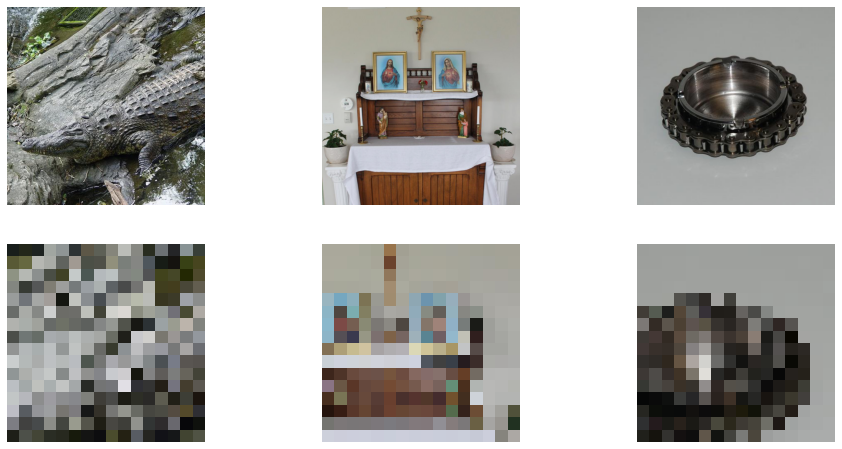

In [16]:
layer = 1
t_te_sim, t_tr_sim, affine_weights, linear_weights, linear_bias = simulated_responses(x_te, x_tr, layer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: "simple_AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: "simple_AFRT._response" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: "simple_AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSeq

Initial scale: [0.], Initial translation: [0. 0.]
Epoch 0: Train loss: 131339.7442 / Test loss: 15544.2363 in 2 seconds
Scale: [0.0345274], translation: [0.02010006 0.0249007 ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: "simple_AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: "simple_AFRT._response" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: "simple_AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSeq

Epoch 15: Train loss: 131103.7461 / Test loss: 13621.6094 in 30 seconds
Scale: [0.3315033], translation: [0.19545542 0.13934377]
Epoch 30: Train loss: 109715.2246 / Test loss: 15054.9443 in 55 seconds
Scale: [0.2566763], translation: [0.17293644 0.06605227]
Epoch 45: Train loss: 118458.1432 / Test loss: 13805.6670 in 81 seconds
Scale: [0.28051963], translation: [0.1971639 0.1251358]
Epoch 60: Train loss: 113134.6793 / Test loss: 2853.0952 in 106 seconds
Scale: [0.19546215], translation: [0.26202828 0.08168337]
Epoch 75: Train loss: 132702.0830 / Test loss: 11557.1973 in 132 seconds
Scale: [0.32770017], translation: [0.31922174 0.14727874]
Epoch 90: Train loss: 173436.4457 / Test loss: 7789.5537 in 158 seconds
Scale: [0.46243814], translation: [ 0.43721035 -0.02620677]
Epoch 105: Train loss: 109361.4614 / Test loss: 17552.1094 in 183 seconds
Scale: [0.46482107], translation: [ 0.6605486  -0.18629338]
Epoch 120: Train loss: 116124.4268 / Test loss: 8406.8193 in 209 seconds
Scale: [0.4324

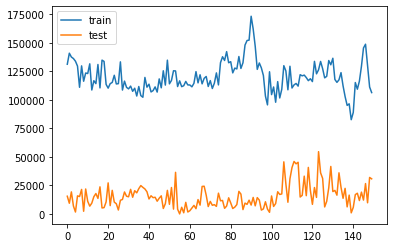

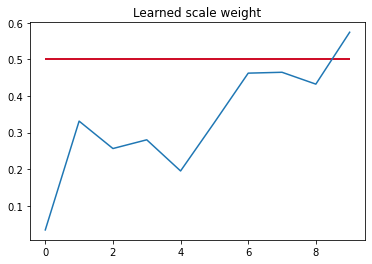

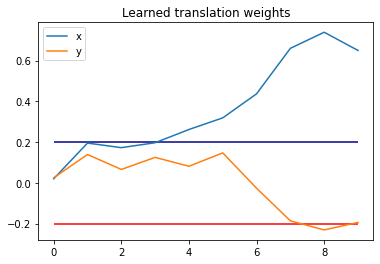

In [20]:
def train(prit=True, prit_init=True, plot=True):
    # Training loop
    batch_size = 9
    lr = 0.005
    wd = 0.001

    def load_dataset(x, t, batch_size):
        return NDArrayIter({ "x": x }, { "t": t }, batch_size, True)

    train = load_dataset(nd.array(x_tr, ctx=ctx), t_tr_sim, batch_size)
    test =  load_dataset(nd.array(x_te, ctx=ctx), t_te_sim, batch_size)

    mse = gluon.loss.L2Loss()

    model = simple_AFRT(layer, linear_weights, linear_bias)
    model.initialize(init=init.Zero(), force_reinit=True, ctx=ctx)
    trainer = gluon.Trainer(model.collect_params(), "Adam", {"learning_rate": lr, "wd": wd})

    # Print initial parameters: (maybe find easier methods)
    if prit or prit_init:
        name = [elem.name for elem in model.collect_params().values()]
        sc = model.collect_params()[name[0]].data()[0].asnumpy()
        tr = model.collect_params()[name[1]].data()[0].asnumpy()
        print("Initial scale: {}, Initial translation: {}".format(sc, tr))

    train_losses = []
    test_losses = []
    scales = []
    tr1 = []
    tr2 = []

    start = time.time()
    n_epochs = 150
    print_int = n_epochs / 10

    for epoch in range(n_epochs):
        train.reset()
        test.reset()
        train_loss, test_loss = 0., 0.
        for batch in train:
            with autograd.record():
                y = model(batch.data[0])
                loss = mse(y, batch.label[0])
            loss.backward()
            trainer.step(batch_size)
            train_loss += loss.mean().asscalar()
        train_loss /= batch_size
        train_losses.append(train_loss)
        
        for batch in test:
            y = model(batch.data[0])
            loss = mse(y, batch.label[0])
            test_loss += loss.mean().asscalar()
        test_loss
        test_losses.append(test_loss)

        t = time.time() - start
        if epoch % print_int == 0:
            if prit:
                print("Epoch %i: Train loss: %.4f / Test loss: %.4f in %.0f seconds" % (epoch, train_loss, test_loss, t))
            name = [elem.name for elem in model.collect_params().values()]
            sc = model.collect_params()[name[0]].data()[0].asnumpy()
            tr = model.collect_params()[name[1]].data()[0].asnumpy()
            if prit:
                print("Scale: {}, translation: {}".format(sc, tr))
            scales.append(sc)
            tr1.append(tr[0])
            tr2.append(tr[1])
    print("Epoch %i: Train loss: %.4f / Test loss: %.4f in %.0f seconds" % (n_epochs, train_loss, test_loss, time.time() - start))
    
    if plot:
        plt.plot(train_losses, label="train")
        plt.plot(test_losses, label="test")
        plt.legend()
        plt.show()
        plt.plot(scales)
        plt.hlines(affine_weights[0], 0, 9, colors='darkblue')
        plt.hlines(affine_weights[4], 0, 9, colors='red')
        plt.title("Learned scale weight")
        plt.show()
        plt.title("Learned translation weights")
        plt.plot(tr1, label="x")
        plt.plot(tr2, label="y")
        plt.hlines(affine_weights[2], 0, 9, colors='darkblue')
        plt.hlines(affine_weights[5], 0, 9, colors='red')
        plt.legend()
        plt.show()
    return train_losses, test_losses, scales, tr1, tr2
    
train_losses, test_losses, scales, tr1, tr2 = train()

-------------------1---------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: "simple_AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: "simple_AFRT._response" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: "simple_AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSeq

Initial scale: [0.], Initial translation: [0. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: "simple_AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: "simple_AFRT._response" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: "simple_AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSeq

Epoch 150: Train loss: 0.0000 / Test loss: 0.0000 in 268 seconds


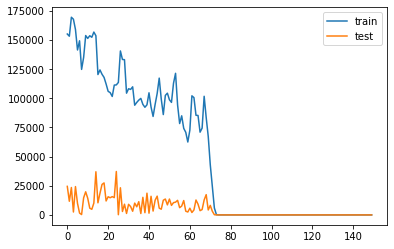

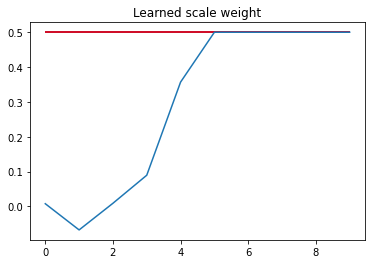

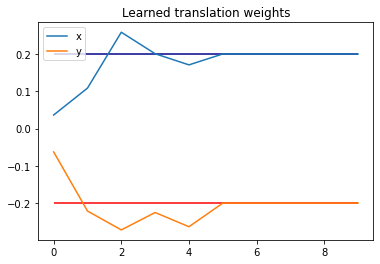

-------------------2---------------------
Initial scale: [0.], Initial translation: [0. 0.]
Epoch 150: Train loss: 115642.3774 / Test loss: 17549.1836 in 275 seconds


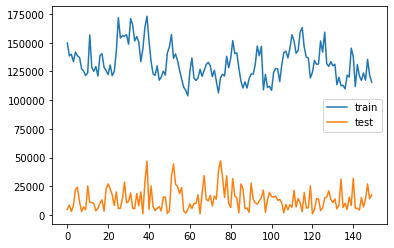

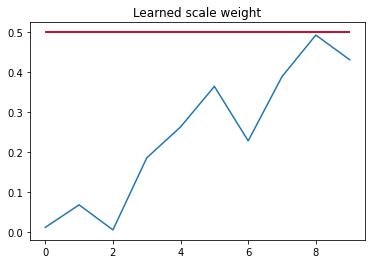

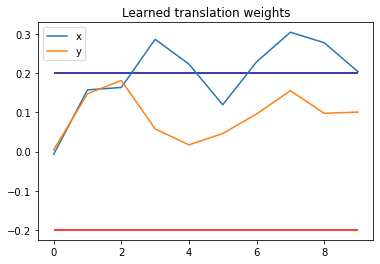

-------------------3---------------------
Initial scale: [0.], Initial translation: [0. 0.]
Epoch 150: Train loss: 150426.0979 / Test loss: 27779.4453 in 279 seconds


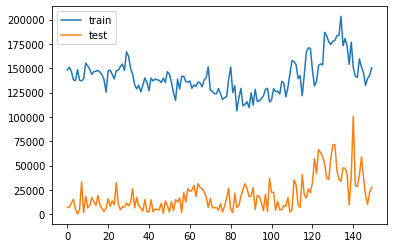

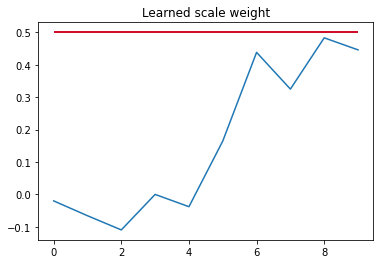

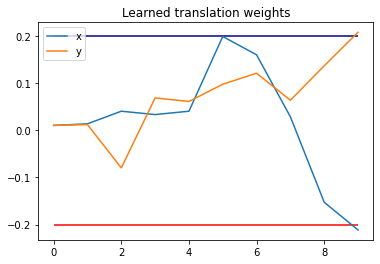

-------------------4---------------------
Initial scale: [0.], Initial translation: [0. 0.]
Epoch 150: Train loss: 117139.4384 / Test loss: 9969.7070 in 268 seconds


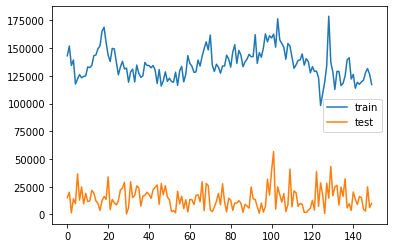

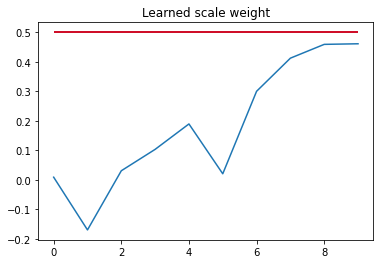

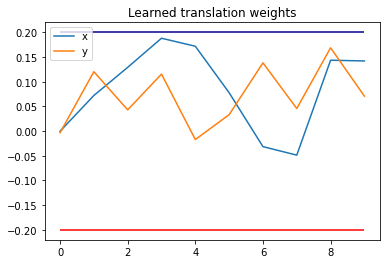

-------------------5---------------------
Initial scale: [0.], Initial translation: [0. 0.]
Epoch 150: Train loss: 121911.4391 / Test loss: 3740.6060 in 266 seconds


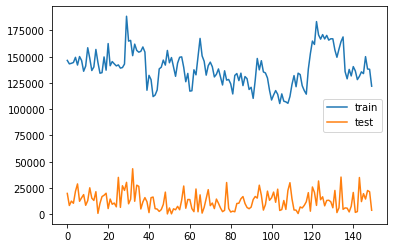

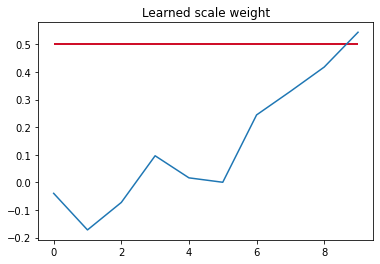

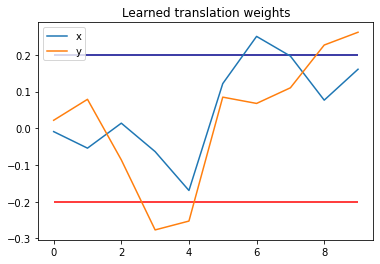

-------------------6---------------------
Initial scale: [0.], Initial translation: [0. 0.]
Epoch 150: Train loss: 150831.9006 / Test loss: 3038.9497 in 273 seconds


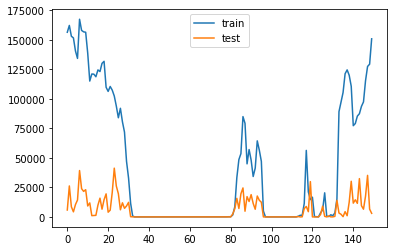

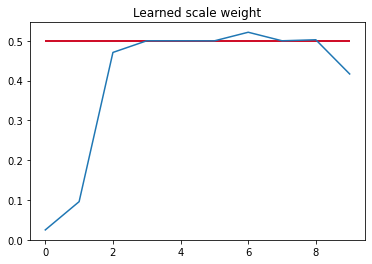

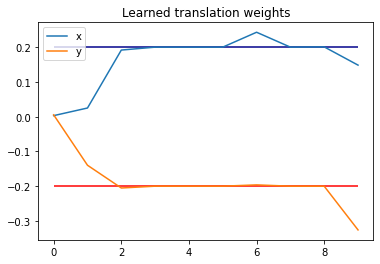

-------------------7---------------------
Initial scale: [0.], Initial translation: [0. 0.]
Epoch 150: Train loss: 0.1433 / Test loss: 0.2259 in 270 seconds


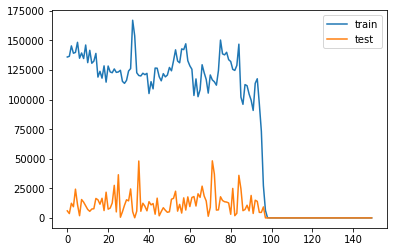

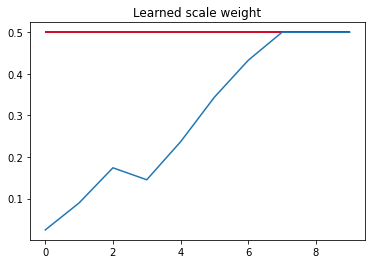

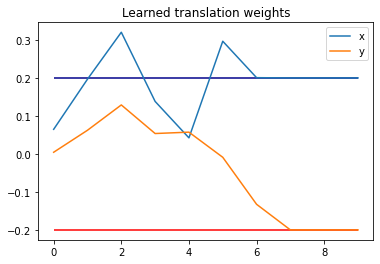

-------------------8---------------------
Initial scale: [0.], Initial translation: [0. 0.]
Epoch 150: Train loss: 155137.3810 / Test loss: 17217.2090 in 265 seconds


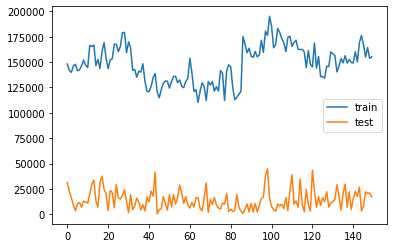

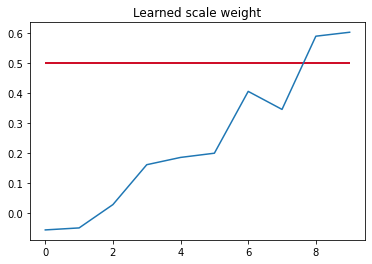

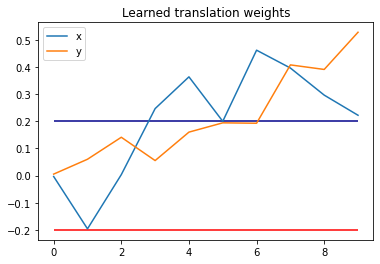

-------------------9---------------------
Initial scale: [0.], Initial translation: [0. 0.]
Epoch 150: Train loss: 168894.4298 / Test loss: 18521.3359 in 262 seconds


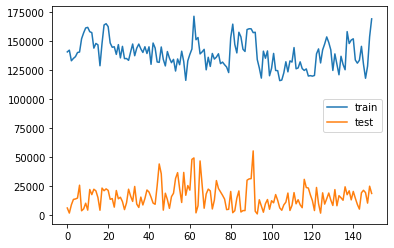

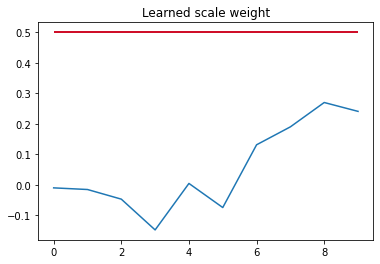

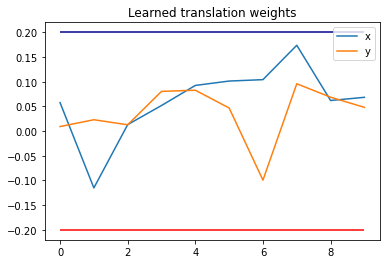

-------------------10---------------------
Initial scale: [0.], Initial translation: [0. 0.]
Epoch 150: Train loss: 0.0000 / Test loss: 0.0000 in 262 seconds


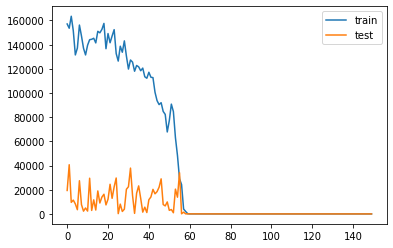

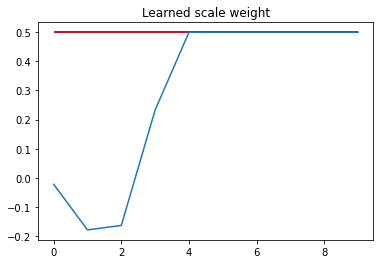

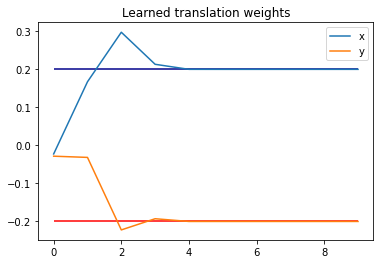

3


In [21]:
def learned(x, y):
    alpha = 0.05
    return x < y + alpha and x > y - alpha

def train_repeat(rep=10):
    correct = 0
    for i in range(rep):
        print("-------------------{}---------------------".format(i + 1))
        
        _, _, scales, tr1, tr2 = train(prit=False, prit_init=True, plot=True)
        t_scale = affine_weights[0]
        t_tr1 = affine_weights[2]
        t_tr2 = affine_weights[5]
        if learned(scales[-1], t_scale) and learned(tr1[-1], t_tr1) and learned(tr2[-1], t_tr2):
            correct += 1
    return correct

correct = train_repeat()
print(correct)

In [ ]:
# Test model
test = load_dataset(nd.array(x_te, ctx=ctx), t_te_sim, batch_size=3)
for batch in test:
    pred = model(batch.data[0])
    print("Pearson R:", sst.pearsonr(pred.asnumpy()[:,0], t_te_sim.asnumpy()[:,0]))
# Pearson r on model prediction and true target

# Retinotopic map:

# Visualization of x_te with new affine parameters
# Get learned parameters:
name = [elem.name for elem in model.collect_params().values()]
sc = model.collect_params()[name[0]].data()[0]
tr = model.collect_params()[name[1]].data()[0]
print(sc.asnumpy(), tr.asnumpy())

# Create Affine layer with new weights
fov = [16, 32, 32, 32, 64, 224, 224, 224]
learned = AffineSimple(fov[layer-1])
learned.initialize(ctx=ctx)
name = [elem.name for elem in learned.params.values()]
learned.params[name[0]].data()[0] = sc
learned.params[name[1]].data()[0] = tr

# Compare to Affine layer with original weights
true = AffineSimple(fov[layer-1])
true.initialize(ctx=ctx)
name = [elem.name for elem in true.params.values()]
true.params[name[0]].data()[0] = affine_weights[0]
true.params[name[1]].data()[0] = [affine_weights[2], affine_weights[5]]

unreg_xte = visualize(x_te, te_means, te_stds)
unreg_learned = learned(nd.array(unreg_xte, ctx=ctx))
unreg_true = true(nd.array(unreg_xte, ctx=ctx))

for i in range(len(x_te)):
    # data type should be uint8, shape should be (size, size, 3)
    img = np.transpose(unreg_xte[i], (1, 2, 0))
    learned_image = np.uint8(np.transpose(unreg_learned[i].asnumpy(), (1, 2, 0)))
    true_image = np.uint8(np.transpose(unreg_true[i].asnumpy(), (1, 2, 0)))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(Image.fromarray(img))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(Image.fromarray(learned_image))
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(Image.fromarray(true_image))
    plt.axis('off')
    plt.show()

In [ ]:
fov = [16, 32, 32, 32, 64, 224, 224, 224]
affine = AffineSimple(fov[layer-1])
affine.initialize(ctx=ctx)
affine_weights = np.array([1.0, 0, 2, 0, 1.0, -2])
name = [elem.name for elem in affine.params.values()]

# Simple:
affine.params[name[0]].data()[0] = affine_weights[0]
affine.params[name[1]].data()[0] = [affine_weights[2], affine_weights[5]]

# Visualize x_te before and after affine transformation, unregularized
x = visualize(x_te, te_means, te_stds)[2]
x_aff = affine(nd.array(nd.array([x]), ctx=ctx))
y = visualize(x_te, te_means, te_stds)[1]

img = Image.fromarray(np.transpose(x, (1, 2, 0)))
affine_image = np.uint8(np.transpose(x_aff[0].asnumpy(), (1, 2, 0)))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Affine Image")
plt.figtext(0.33, 0.12, "scaling = 1.0, translation_x = 2.0, translation_y = -2.0", horizontalalignment="left", fontsize=12)
plt.imshow(Image.fromarray(affine_image))
plt.axis('off')
plt.show()